In [1]:
import pandas as pd
import math
data = pd.read_csv('house-prices.csv')
data.SalePrice = data.SalePrice.apply(math.log) 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
import xgboost
from sklearn import tree
from sklearn.decomposition import PCA

### Splitting
Let’s split this data into labels and features.

In [4]:
#data_all = data.copy()
X = data.drop('SalePrice', axis = 1)
y = data['SalePrice']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(1168, 80)
(292, 80)


Let's check which feature is most related to house prices. For this, I'll use a correlation matrix.

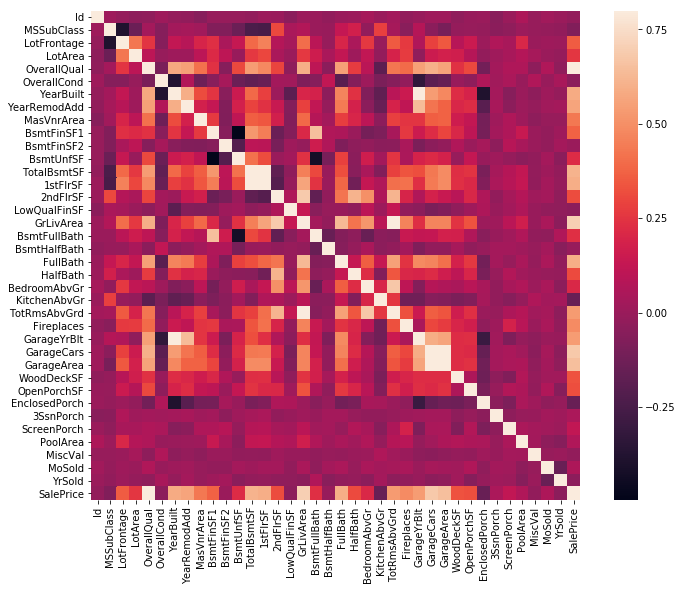

In [5]:
corr_mat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

Top 50% Corralation train attributes with sale-price

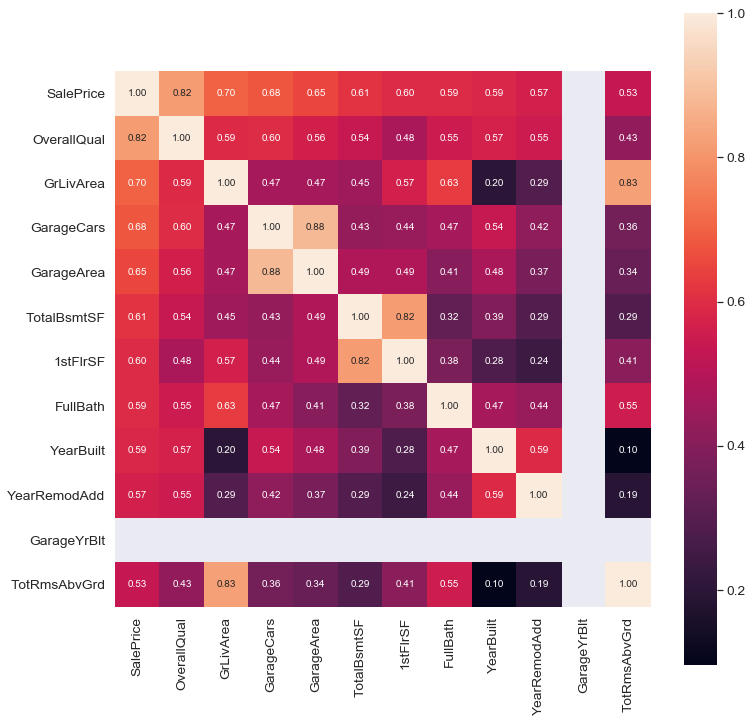

In [6]:
k = 12 #number of variables for heatmap
plt.figure(figsize=(12, 12))
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

Some algorithms are sensitive to outliers. Let's look on top 10 correlation train attributes and show them on the charts.

<Figure size 720x720 with 0 Axes>

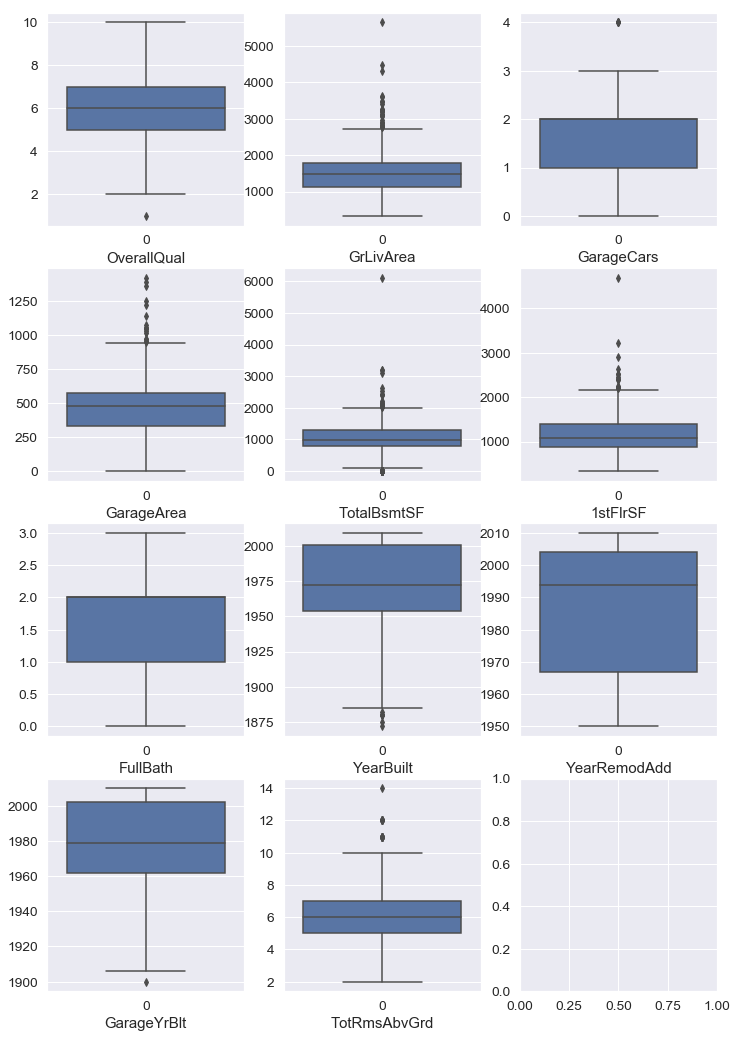

In [7]:
plt.figure(figsize=(10, 10))
i=0
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(12,18))

for col in cols[1:]:
    ax = sns.boxplot(data = X_train[col], ax=axs[i // 3][i % 3])
    ax.set(xlabel=col)
    i+=1

For detect outliers in data will use interquartile range.

https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/interquartile-range/

In [8]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

In [9]:
all_data = X_train.copy()
all_data['price'] = y_train
X_train_IQ = all_data[~((X_train[cols[1:]] < (Q1 - 1.5 * IQR)) |(X_train[cols[1:]] > (Q3 + 1.5 * IQR))).any(axis=1)]
y_IQ = X_train_IQ['price']
X_train_IQ.drop('price', axis = 1, inplace=True)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
print('Count of rows before detecting outliers:')
print(X_train.shape[0])
print('And after:')
print(X_train_IQ.shape[0])

Count of rows before detecting outliers:
1168
And after:
1064


In [11]:
# Combining Datasets
ntrain = X_train_IQ.shape[0]
ntest = X_test.shape[0]
y_train = y_IQ
all_data = pd.concat((X_train_IQ, X_test)).reset_index(drop=True)


#### Imputing Missing Values
A lot of machine learning algorithms can't work with NaN value. Next step is to detect NaN values in the data set.

In [12]:
columns_null = all_data.loc[:,all_data.isnull().sum()>0].columns
all_data[columns_null].isnull().sum()

LotFrontage      241
Alley           1271
MasVnrType         7
MasVnrArea         7
BsmtQual           7
BsmtCond           7
BsmtExposure       8
BsmtFinType1       7
BsmtFinType2       7
Electrical         1
FireplaceQu      653
GarageType        72
GarageYrBlt       72
GarageFinish      72
GarageQual        72
GarageCond        72
PoolQC          1353
Fence           1091
MiscFeature     1308
dtype: int64

For Alley NaN means -  "no alley access". For attributes like this NaN will be replaced to "No". For other attributes using 'mode' value or 0.

In [13]:
def data_fillna(data):   
    data_fill = data.copy()
    data_fill['Alley'] = data['Alley'].fillna("No")
    data_fill['MasVnrType'] = data['MasVnrType'].fillna('No')
    data_fill['MasVnrArea'] = data['MasVnrArea'].fillna('0')
    data_fill['BsmtQual'] = data['BsmtQual'].fillna('No')
    data_fill['BsmtCond'] = data['BsmtCond'].fillna('No')
    data_fill['BsmtExposure'] = data['BsmtExposure'].fillna('No')
    data_fill['BsmtFinType1'] = data['BsmtFinType1'].fillna('No')
    data_fill['BsmtFinType2'] = data['BsmtFinType2'].fillna('No')
    data_fill['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
    data_fill['FireplaceQu'] = data['FireplaceQu'].fillna('No')
    data_fill['GarageType'] = data['GarageType'].fillna('No')
    data_fill['GarageYrBlt'] = data['GarageYrBlt'].fillna('0')
    data_fill['GarageFinish'] = data['GarageFinish'].fillna('No')
    data_fill['GarageQual'] = data['GarageQual'].fillna('No')
    data_fill['GarageCond'] = data['GarageCond'].fillna('No')
    data_fill['PoolQC'] = data['PoolQC'].fillna('No')
    data_fill['Fence'] = data['Fence'].fillna('No')
    data_fill['MiscFeature'] = data['MiscFeature'].fillna('No')
#    data_fill['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data_fill["LotFrontage"] = data['LotFrontage'].fillna(data['LotFrontage'].mode()[0])
    return data_fill

In [14]:
X_train_fill = data_fillna(all_data)

Some attributes have an implicit order. For example, ExterQual takes 'Ex' value (means Excellent) or 'Po' value (Poor) and it is obvious that Ex better than Po.
Let's encode these labels to give meaning to their specific orders.

In [15]:
columns_cat = ['MSSubClass', 'OverallQual', 'OverallCond', 'Street',  'Alley', 'LotShape', 'ExterQual', 'ExterCond', 
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
                      'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'LandSlope']

In [16]:
def data_label_encoder(data, column_list):
    data_encoder = data.copy()
    for c in column_list:
        lbl = LabelEncoder() 
  #      data_encoder[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
        lbl.fit(list(data_encoder[c].values)) 
        data_encoder[c] = lbl.transform(list(data_encoder[c].values))
#    data_encoder[column_list] = data_encoder[column_list].astype('category')
    return data_encoder

In [17]:
X_train_encode = data_label_encoder(X_train_fill, columns_cat)

drop Id and transform some attributes into categorical features

In [18]:
X_train_encode.drop('Id', axis = 1, inplace=True)
X_train_encode['OverallCond'] = X_train_encode['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
X_train_encode['YrSold'] = X_train_encode['YrSold'].astype(str)
X_train_encode['MoSold'] = X_train_encode['MoSold'].astype(str)


https://becominghuman.ai/how-to-deal-with-skewed-dataset-in-machine-learning-afd2928011cc
    
Here, we fix all of the skewed data to be more normal so that our models will be more accurate when making predictions.

In [19]:
numeric_feats = X_train_encode.dtypes[X_train_encode.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X_train_encode[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,29.164872
PoolArea,21.515346
LotArea,11.200459
LowQualFinSF,10.758101
3SsnPorch,10.154730


In [20]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X_train_encode[feat] = boxcox1p(X_train_encode[feat], lam)
    X_train_encode[feat] += 1

There are 51 skewed numerical features to Box Cox transform


For the remaining attributes will be used one-hot encoding.

In [21]:
col_one_hot = ['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 
               'CentralAir', 'Electrical', 'Functional', 'GarageType', 'SaleCondition', 'MiscFeature', 'SaleType']

In [22]:
all_data = pd.get_dummies(data=X_train_encode, columns=col_one_hot)
print(all_data.shape)

(1356, 223)


The last step of preprocessing - scale data and split them again to train and test sets.

In [23]:
scaler = StandardScaler()
all_data=scaler.fit_transform(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


To find the best hyperparameters in all models used GridSearchCV.

The first implemented algorithm is decision trees.
#### DecisionTreeRegressor

In [24]:
# Decision tree with a depth of 3 to 20.
parameters = {'max_depth':range(3,20)}
dt = GridSearchCV(tree.DecisionTreeRegressor(), parameters, cv = 5, n_jobs=-1)
dt.fit(train, y_IQ)
dt_model = dt.best_estimator_
print (dt.best_score_, dt.best_params_) 

0.6924037440939161 {'max_depth': 10}


In [25]:
y_dec_tree = dt_model.predict(test)
print('RMSLE for DecisionTreeRegressor: ', np.sqrt(np.mean(np.square(y_dec_tree - y_test))))

RMSLE for DecisionTreeRegressor:  0.19194223866557616


A random forest regressor.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    
Maybe it possible to find better parameters, but it'll take too much time.    
#### RandomForestRegressor

In [26]:
parameters = [{
    'max_depth': range(5,10),
    "n_estimators": [10, 50, 100, 150],
#   "min_samples_split": [4, 6, 8, 10],
#   "min_samples_leaf": [1, 2, 4]
}]
rf = GridSearchCV(RandomForestRegressor(), parameters, cv=5)
rf.fit(train, y_IQ)
rf_model = rf.best_estimator_
print("Random forest: best score- {}, best params- {}".format(rf.best_score_, rf.best_params_))

Random forest: best score- 0.8426196600687973, best params- {'max_depth': 9, 'n_estimators': 150}


In [27]:
y_pred = rf.predict(test)
print('RMSLE for Random forest: ', np.sqrt(np.mean(np.square(y_pred - y_test))))


RMSLE for Random forest:  0.14301722515907225


#### XGBRegressor

In [28]:
parameters = [{
    'max_depth': range(5, 10),
    "n_estimators": [70, 100, 120],
#    'earning_rate': [0.08, 0.09, 0.1]
}]
xgb = GridSearchCV(xgboost.XGBRegressor(), parameters, cv=5, n_jobs=-1)
xgb.fit(train, y_IQ)
xgb_model = xgb.best_estimator_
print("XGBRegressor: best score- {}, best params- {}".format(xgb.best_score_, xgb.best_params_))

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor: best score- 0.8752148538473165, best params- {'max_depth': 5, 'n_estimators': 120}


In [29]:
y_xgb = xgb_model.predict(test)
print('RMSLE for XGBRegressor: ', np.sqrt(np.mean(np.square(y_xgb - y_test))))

RMSLE for XGBRegressor:  0.12811942154779857


Best Results we have obtained with the regressor XGBRegressor. Also with these parameters it works faster than others.

In the next part, I was trying to reduce the dimension of the data by PCA. For tests was using XGBRegressor with the best hyperparameters from the previous part.
#### PCA

In [33]:
pca_k = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
num_f = []
acc = []
for k in pca_k:
    pca = PCA(k)
    pca.fit(all_data)
    X_pca = pca.fit_transform(all_data)
    train = X_pca[:ntrain]
    test = X_pca[ntrain:]
    xgb = xgboost.XGBRegressor(max_depth= 5, n_estimators= 120)
    xgb.fit(train, y_IQ)  
    y_xgb_pca = xgb.predict(test) 
    rmse = np.sqrt(np.mean(np.square(y_xgb_pca - y_test)))
    acc.append(rmse)
    num_f.append(train.shape[1])
    print(train.shape, rmse)

c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 71) 0.14376088186719807


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 81) 0.14839460312938038


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 93) 0.14727661306684386


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 107) 0.14879026526131084


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 123) 0.14679615243344896


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 144) 0.14324492187682825


c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\анастасия\appdata\local\programs\python\python35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(1064, 173) 0.14504679456649683


The chart below shows addiction RMSLE by attributes count. 

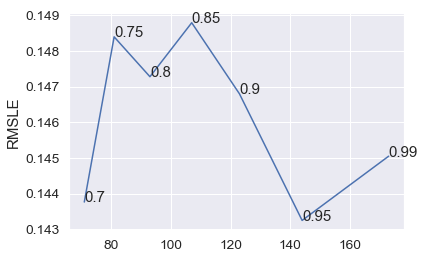

In [34]:
i =0
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(num_f, acc)
plt.ylabel('RMSLE')
for xy in zip(num_f, acc):                                      
    ax.annotate(pca_k[i], xy=xy)
    i+=1
plt.show()